# 双节倒立摆 Acrobot-v1

In [1]:
%matplotlib inline
import numpy as np
np.random.seed(0)
from scipy.special import xlogy
import pandas as pd
import gym
import tensorflow as tf
from tensorflow import keras
try: # tf2
    tf.random.set_seed(0)
    from tensorflow.keras.initializers import GlorotUniform
    from tensorflow.keras.optimizers import Adam
except: # tf1
    tf.enable_eager_execution()
    tf.random.set_random_seed(0)
    from tensorflow import glorot_uniform_initializer as GlorotUniform
    from tensorflow.train import AdamOptimizer as Adam
import matplotlib.pyplot as plt

In [2]:
env = gym.make('Acrobot-v1')
env.seed(0)

[0]

### 用简单的执行者评论家算法寻找最优策略

In [3]:
class QActorCriticAgent:
    def __init__(self, env, actor_kwargs, critic_kwargs, gamma=0.99):
        self.action_n = env.action_space.n
        self.gamma = gamma
        self.discount = 1.

        self.actor_net = self.build_network(output_size=self.action_n,
                output_activation=tf.nn.softmax,
                loss=keras.losses.categorical_crossentropy,
                **actor_kwargs)
        self.critic_net = self.build_network(output_size=self.action_n,
                **critic_kwargs)
    
    def build_network(self, hidden_sizes, output_size,
                activation=tf.nn.relu, output_activation=None,
                loss=keras.losses.mse, learning_rate=0.01):
        model = keras.Sequential()
        for hidden_size in hidden_sizes:
            model.add(keras.layers.Dense(units=hidden_size,
                    activation=activation,
                    kernel_initializer=GlorotUniform(seed=0)))
        model.add(keras.layers.Dense(units=output_size,
                activation=output_activation,
                kernel_initializer=GlorotUniform(seed=0)))
        optimizer = Adam(learning_rate)
        model.compile(optimizer=optimizer, loss=loss)
        return model
      
    def decide(self, observation):
        probs = self.actor_net.predict(observation[np.newaxis])[0]
        action = np.random.choice(self.action_n, p=probs)
        return action
        
    def learn(self, observation, action, reward, next_observation, done):
        # 训练执行者网络
        x = observation[np.newaxis]
        u = self.critic_net.predict(x)
        q = u[0, action]
        x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
        with tf.GradientTape() as tape:
            pi_tensor = self.actor_net(x_tensor)[0, action]
            logpi_tensor = tf.math.log(tf.clip_by_value(pi_tensor,
                    1e-6, 1.))
            loss_tensor = -self.discount * q * logpi_tensor
        grad_tensors = tape.gradient(loss_tensor, self.actor_net.variables)
        self.actor_net.optimizer.apply_gradients(zip(
                grad_tensors, self.actor_net.variables))
        
        # 训练评论者网络
        q = self.critic_net.predict(next_observation[np.newaxis])[0, action]
        u[0, action] = reward + (1. - done) * self.gamma * q
        self.critic_net.fit(x, u, verbose=0)
        
        if done:
            self.discount = 1.
        else:
            self.discount *= self.gamma

In [4]:
def play_qlearning(env, agent, train=False, render=False):
    episode_reward = 0
    observation = env.reset()
    step = 0
    while True:
        if render:
            env.render()
        action = agent.decide(observation)
        next_observation, reward, done, _ = env.step(action)
        episode_reward += reward
        if train:
            agent.learn(observation, action, reward, next_observation,
                    done)
        if done:
            break
        step += 1
        observation = next_observation
    return episode_reward

平均回合奖励 = -19512.0 / 100 = -195.12


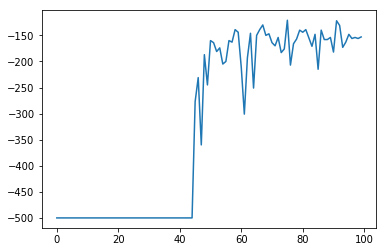

In [5]:
actor_kwargs = {'hidden_sizes' : [100,], 'activation' : tf.nn.relu, 
        'learning_rate' : 0.0005}
critic_kwargs = {'hidden_sizes' : [100,], 'activation' : tf.nn.relu, 
        'learning_rate' : 0.0005}
agent = QActorCriticAgent(env, actor_kwargs=actor_kwargs,
        critic_kwargs=critic_kwargs)

# 训练
episodes = 100
episode_rewards = []
for episode in range(episodes):
    episode_reward = play_qlearning(env, agent, train=True)
    episode_rewards.append(episode_reward)
plt.plot(episode_rewards);

# 测试
episode_rewards = [play_qlearning(env, agent, train=False) \
        for _ in range(100)]
print('平均回合奖励 = {} / {} = {}'.format(sum(episode_rewards),
        len(episode_rewards), np.mean(episode_rewards)))

优势执行者/评论者算法

In [6]:
class AdvantageActorCriticAgent:
    def __init__(self, env, actor_kwargs, critic_kwargs, gamma=0.99):
        self.action_n = env.action_space.n
        self.gamma = gamma
        self.discount = 1.

        self.actor_net = self.build_network(output_size=self.action_n,
                output_activation=tf.nn.softmax,
                loss=keras.losses.categorical_crossentropy,
                **actor_kwargs)
        self.critic_net = self.build_network(output_size=1,
                **critic_kwargs)
    
    def build_network(self, hidden_sizes, output_size,
                activation=tf.nn.relu, output_activation=None,
                loss=keras.losses.mse, learning_rate=0.01):
        model = keras.Sequential()
        for hidden_size in hidden_sizes:
            model.add(keras.layers.Dense(units=hidden_size,
                    activation=activation,
                    kernel_initializer=GlorotUniform(seed=0)))
        model.add(keras.layers.Dense(units=output_size,
                activation=output_activation,
                kernel_initializer=GlorotUniform(seed=0)))
        optimizer = keras.optimizers.Adam(learning_rate)
        model.compile(optimizer=optimizer, loss=loss)
        return model
      
    def decide(self, observation):
        probs = self.actor_net.predict(observation[np.newaxis])[0]
        action = np.random.choice(self.action_n, p=probs)
        return action
        
    def learn(self, observation, action, reward, next_observation, done):
        x = observation[np.newaxis]
        u = reward + (1. - done) * self.gamma * \
                self.critic_net.predict(next_observation[np.newaxis])
        td_error = u - self.critic_net.predict(x)
        y = self.discount * td_error * \
                np.eye(self.action_n)[np.newaxis, action]
        self.actor_net.fit(x, y, verbose=0)
        self.critic_net.fit(x, u, verbose=0)
        
        if done:
            self.discount = 1.
        else:
            self.discount *= self.gamma

In [7]:
def play_qlearning(env, agent, train=False, render=False):
    episode_reward = 0
    observation = env.reset()
    while True:
        if render:
            env.render()
        action = agent.decide(observation)
        next_observation, reward, done, _ = env.step(action)
        episode_reward += reward
        if train:
            agent.learn(observation, action, reward, next_observation,
                    done)
        if done:
            break
        observation = next_observation
    return episode_reward

平均回合奖励 = -10550.0 / 100 = -105.5


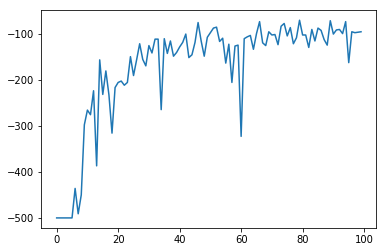

In [8]:
actor_kwargs = {'hidden_sizes' : [100,], 'activation' : tf.nn.relu, 
        'learning_rate' : 0.0001}
critic_kwargs = {'hidden_sizes' : [100,], 'activation' : tf.nn.relu, 
        'learning_rate' : 0.0002}
agent = AdvantageActorCriticAgent(env, actor_kwargs=actor_kwargs,
        critic_kwargs=critic_kwargs)

# 训练
episodes = 100
episode_rewards = []
for episode in range(episodes):
    episode_reward = play_qlearning(env, agent, train=True)
    episode_rewards.append(episode_reward)
    
plt.plot(episode_rewards);

# 测试
episode_rewards = [play_qlearning(env, agent, train=False) \
        for _ in range(100)]
print('平均回合奖励 = {} / {} = {}'.format(sum(episode_rewards),
        len(episode_rewards), np.mean(episode_rewards)))

### 邻近策略优化

In [9]:
class PPOReplayer:
    def __init__(self):
        self.memory = pd.DataFrame()
    
    def store(self, df):
        self.memory = pd.concat([self.memory, df], ignore_index=True)
        
    def sample(self, size):
        indices = np.random.choice(self.memory.shape[0], size=size)
        return (np.stack(self.memory.loc[indices, field]) for field \
                in self.memory.columns)

class PPOAgent(AdvantageActorCriticAgent):
    def __init__(self, env, actor_kwargs, critic_kwargs, clip_ratio=0.1,
            gamma=0.99, lambd=0.99, min_trajectory_length=1000,
            batches=1, batch_size=64):
        self.action_n = env.action_space.n
        self.gamma = gamma
        self.lambd = lambd
        self.min_trajectory_length = min_trajectory_length
        self.batches = batches
        self.batch_size = batch_size
        
        self.trajectory = []
        self.replayer = PPOReplayer()
        
        def ppo_loss(y_true, y_pred): # 损失函数
            # 真实值 y_true : (2*action_n,) 旧策略的策略概率 + 优势函数
            # 预测值 y_pred : (action,) 神经网络输出的策略概率 """
            p = y_pred
            p_old = y_true[:, :self.action_n]
            advantage = y_true[:, self.action_n:]
            surrogate_advantage = (p / p_old) * advantage
            clip_times_advantage = clip_ratio * advantage
            max_surrogate_advantage = advantage + tf.where(advantage > 0.,
                    clip_times_advantage, -clip_times_advantage)
            clipped_surrogate_advantage = tf.minimum(surrogate_advantage,
                    max_surrogate_advantage)
            return -tf.reduce_mean(clipped_surrogate_advantage, axis=-1)
        
        self.actor_net = self.build_network(output_size=self.action_n,
                output_activation=tf.nn.softmax, loss=ppo_loss,
                **actor_kwargs)
        self.critic_net = self.build_network(output_size=1,
                **critic_kwargs)
        
    def learn(self, observation, action, reward, done):
        self.trajectory.append((observation, action, reward))
        
        if done:
            df = pd.DataFrame(self.trajectory, columns=['observation',
                    'action', 'reward'])
            observations = np.stack(df['observation'])
            df['v'] = self.critic_net.predict(observations)
            pis = self.actor_net.predict(observations)
            df['pi'] = [a.flatten() for a in np.split(pis, pis.shape[0])]
            
            df['next_v'] = df['v'].shift(-1).fillna(0.)
            df['u'] = df['reward'] + self.gamma * df['next_v']
            df['delta'] = df['u'] - df['v']
            df['return'] = df['reward']
            df['advantage'] = df['delta']
            for i in df.index[-2::-1]:
                df.loc[i, 'return'] += self.gamma * df.loc[i + 1, 'return']
                df.loc[i, 'advantage'] += self.gamma * self.lambd * \
                        df.loc[i + 1, 'advantage']
            fields = ['observation', 'action', 'pi', 'advantage', 'return']
            self.replayer.store(df[fields])
            self.trajectory = []
            
            if len(self.replayer.memory) > self.min_trajectory_length:
                for batch in range(self.batches):
                    observations, actions, pis, advantages, returns = \
                            self.replayer.sample(size=self.batch_size)
                    ext_advantages = np.zeros_like(pis)
                    ext_advantages[range(self.batch_size), actions] = \
                            advantages
                    actor_targets = np.hstack([pis, ext_advantages])
                    self.actor_net.fit(observations, actor_targets, verbose=0)
                    self.critic_net.fit(observations, returns, verbose=0)
                    
                self.replayer = PPOReplayer()

In [10]:
def play_montecarlo(env, agent, render=False, train=False):
    observation = env.reset()
    episode_reward = 0.
    while True:
        if render:
            env.render()
        action = agent.decide(observation)
        next_observation, reward, done, _ = env.step(action)
        episode_reward += reward
        if train:
            agent.learn(observation, action, reward, done)
        if done:
            break
        observation = next_observation
    return episode_reward

平均回合奖励 = -13703.0 / 100 = -137.03


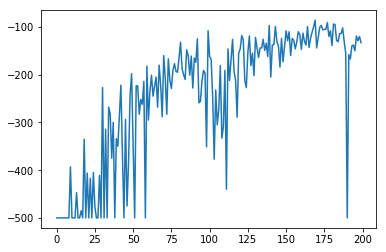

In [11]:
actor_kwargs = {'hidden_sizes' : [100,], 'activation' : tf.nn.relu, 
        'learning_rate' : 0.001}
critic_kwargs = {'hidden_sizes' : [100,], 'activation' : tf.nn.relu, 
        'learning_rate' : 0.002}
agent = PPOAgent(env, actor_kwargs=actor_kwargs,
        critic_kwargs=critic_kwargs, batches=80)

# 训练
episodes = 200
episode_rewards = []
for episode in range(episodes):
    episode_reward = play_montecarlo(env, agent, train=True)
    episode_rewards.append(episode_reward)
    
plt.plot(episode_rewards);

# 测试
episode_rewards = [play_montecarlo(env, agent, train=False) 
        for _ in range(100)]
print('平均回合奖励 = {} / {} = {}'.format(sum(episode_rewards),
        len(episode_rewards), np.mean(episode_rewards)))

In [18]:
env.close()